In [1]:
from tqdm import tqdm
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

from aishell1 import get_dataset_iterator_aishell

In [2]:
def stream_to_pickle(output_file, batch_size=1000):
    iterator = get_dataset_iterator_aishell()
    buffer = []
    
    for item in tqdm(iterator, desc="Streaming and Saving to Pickle"):
        buffer.append({
            'file': item.file,
            'audio': item.audio,
            'file2': item.file2,
            'instruction': item.instruction,
            'label': item.label,
        })
        if len(buffer) >= batch_size:
            with open(output_file, 'ab') as f:
                pickle.dump(buffer, f)
            buffer = []

    if buffer:
        with open(output_file, 'ab') as f:
            pickle.dump(buffer, f)

In [ ]:
stream_to_pickle('aishell_data.pkl')

In [11]:
data = []
with open('aishell_data.pkl', 'rb') as f:
    try:
        while True:
            data.extend(pickle.load(f))
    except EOFError:
        pass

In [15]:
df = pd.DataFrame(data)
# 120418 записей
df.shape

(120418, 5)

In [16]:
df['audio_path'] = df['audio'].apply(lambda x: x['path'])
df['audio_array'] = df['audio'].apply(lambda x: x['array'])
df['sampling_rate'] = df['audio'].apply(lambda x: x['sampling_rate'])

In [18]:
df.drop(columns=['audio'], inplace=True)

In [19]:
df.head()

,file,file2,instruction,label,audio_path,audio_array,sampling_rate
0,BAC009S0002W0122.wav,BAC009S0122W0262.wav,Listen carefully to both audio recordings and ...,no,BAC009S0002W0122.wav,"[-0.000335693359375, -0.00054931640625, -0.000...",16000
1,BAC009S0002W0123.wav,BAC009S0340W0484.wav,Analyze the first audio recording and determin...,no,BAC009S0002W0123.wav,"[-0.000213623046875, -0.000274658203125, 0.0, ...",16000
2,BAC009S0002W0124.wav,BAC009S0002W0410.wav,Listen carefully to both audio recordings and ...,yes,BAC009S0002W0124.wav,"[-0.0003662109375, -0.000396728515625, -0.0003...",16000
3,BAC009S0002W0125.wav,BAC009S0002W0138.wav,Assess whether the two audio recordings are sp...,yes,BAC009S0002W0125.wav,"[-0.000457763671875, -0.000701904296875, -0.00...",16000
4,BAC009S0002W0126.wav,BAC009S0176W0282.wav,Compare the voices in the two audio recordings...,no,BAC009S0002W0126.wav,"[-0.000701904296875, -0.001129150390625, -0.00...",16000


In [20]:
# Сбалансированный датасет
df['label'].value_counts()

label
yes    60218
no     60200
Name: count, dtype: int64

### Смотрим на длительнось аудио

In [21]:
df['duration'] = df.apply(lambda row: len(row['audio_array']) / row['sampling_rate'] if row['sampling_rate'] > 0 else 0, axis=1)

print("\nDuration Statistics:")
print(df['duration'].describe())


Duration Statistics:
count    120418.000000
mean          4.521870
std           1.360632
min           0.000000
25%           3.493875
50%           4.262219
75%           5.326875
max          14.531250
Name: duration, dtype: float64


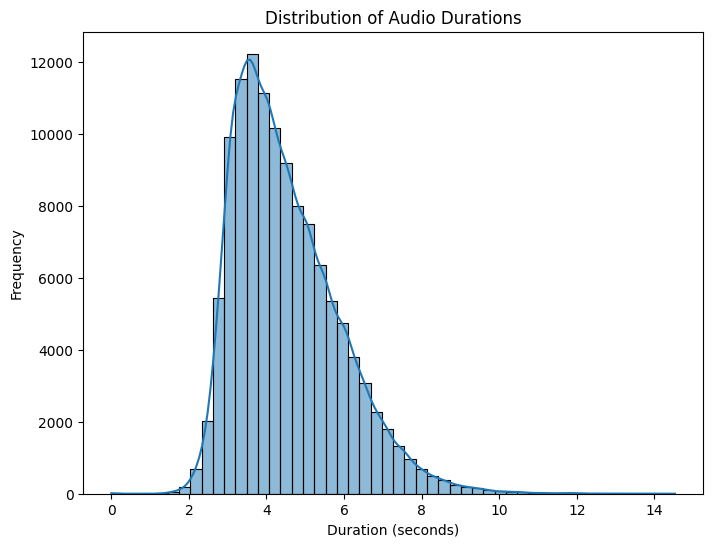

In [22]:
plt.figure(figsize=(8,6))
sns.histplot(df['duration'], bins=50, kde=True)
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

### Смотрим на текст инструкций

In [23]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

df['clean_instruction'] = df['instruction'].apply(clean_text)

In [24]:
df['tokens'] = df['clean_instruction'].apply(nltk.word_tokenize)
df['transcript_length'] = df['tokens'].apply(len)

In [25]:
print("\nTranscript Length Statistics:")
print(df['transcript_length'].describe())


Transcript Length Statistics:
count    120418.000000
mean         23.226760
std           4.675406
min          17.000000
25%          21.000000
50%          24.000000
75%          25.000000
max          39.000000
Name: transcript_length, dtype: float64


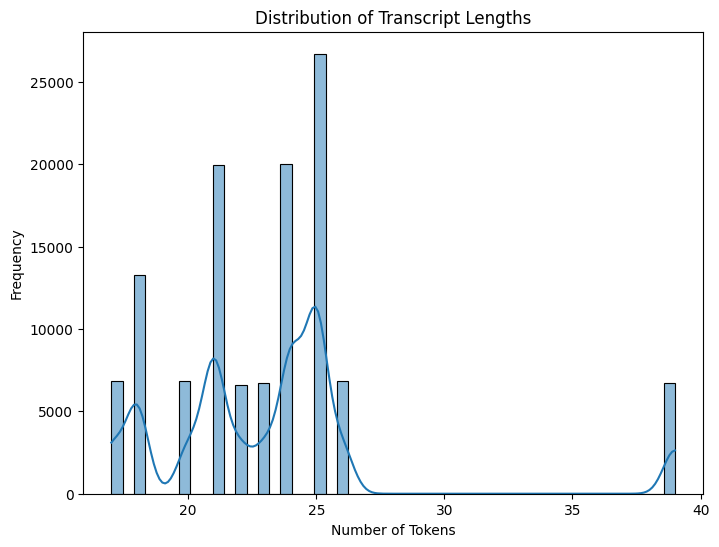

In [26]:
plt.figure(figsize=(8,6))
sns.histplot(df['transcript_length'], bins=50, kde=True)
plt.title('Distribution of Transcript Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [27]:
# Довольно небольшой размер словаря
all_tokens = [token for tokens in df['tokens'] for token in tokens]
vocab = set(all_tokens)
print("\nVocabulary Size:", len(vocab))


Vocabulary Size: 59


### Смотрим N-граммы

In [29]:
bigrams = list(ngrams(all_tokens, 2))
bigram_counts = Counter(bigrams)
print("\nTop 20 Most Common Bigrams:")
print(bigram_counts.most_common(20))


Top 20 Most Common Bigrams:
[(('the', 'answer'), 120418), (('answer', 'could'), 120418), (('could', 'be'), 120418), (('be', 'yes'), 120418), (('yes', 'or'), 120418), (('or', 'no'), 120418), (('the', 'same'), 113848), (('audio', 'recordings'), 113769), (('the', 'two'), 93859), (('two', 'audio'), 93859), (('in', 'the'), 60150), (('spoken', 'by'), 53777), (('by', 'the'), 53777), (('same', 'individual'), 53382), (('individual', 'the'), 53382), (('recordings', 'and'), 53355), (('if', 'they'), 53355), (('same', 'person'), 40416), (('are', 'spoken'), 33565), (('belong', 'to'), 33456)]


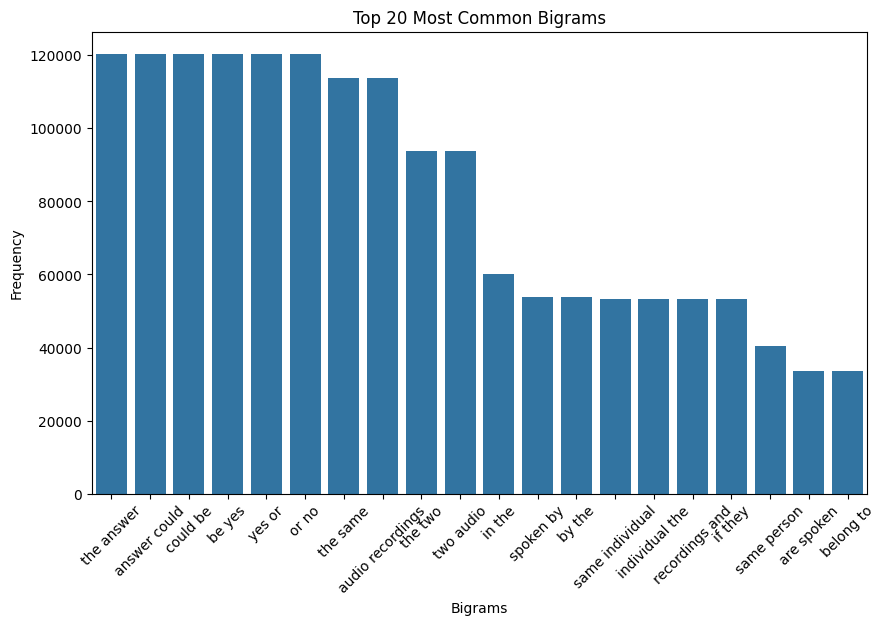

In [30]:
top_bigrams = bigram_counts.most_common(20)
bigrams_list, bigram_freq = zip(*top_bigrams)
bigrams_joined = [' '.join(bigram) for bigram in bigrams_list]

plt.figure(figsize=(10,6))
sns.barplot(x=list(bigrams_joined), y=list(bigram_freq))
plt.title('Top 20 Most Common Bigrams')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [31]:
def generate_ngram_wordcloud(tokens_list, n, max_words):
    ngram_counts = Counter()
    for tokens in tokens_list:
        ngram_counts.update(ngrams(tokens, n))
    
    ngram_freq = {' '.join(gram): count for gram, count in ngram_counts.items()}
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate_from_frequencies(ngram_freq)
    
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of {n}-grams in Instruction', fontsize=20)
    plt.show()

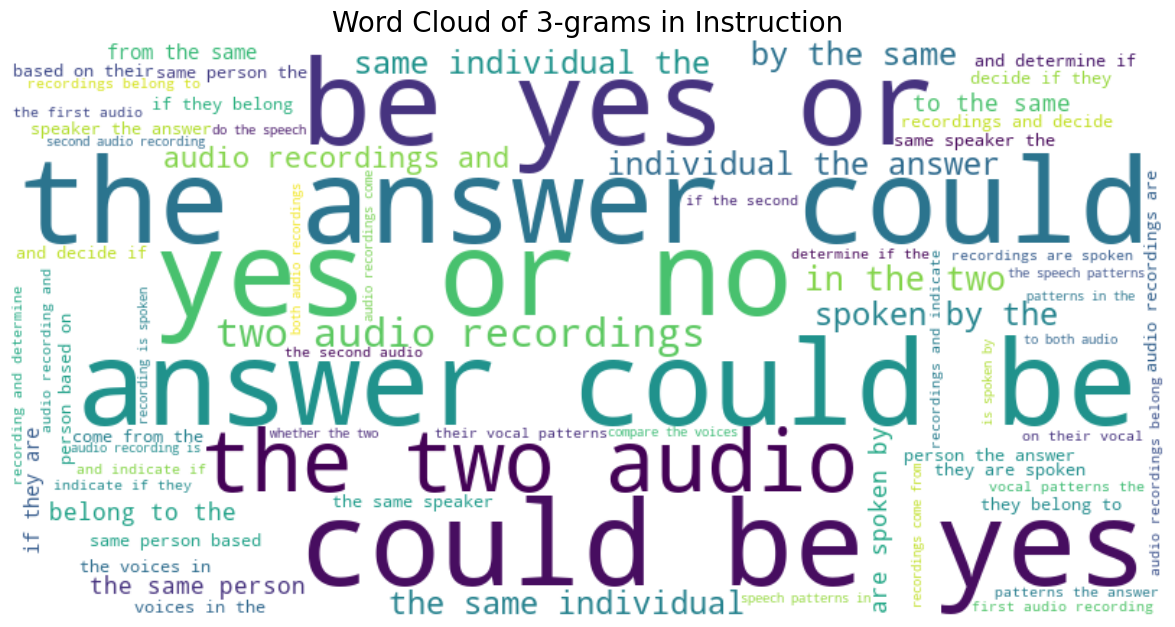

In [32]:
generate_ngram_wordcloud(df['tokens'], n=3, max_words=70)